In [ ]:
import sklearn
import os
from tqdm.autonotebook import tqdm
import numpy as np
from PIL import Image
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model, Model 
from keras.layers import Conv2D, MaxPool2D, Add, Dense, Reshape, Flatten, Dropout, BatchNormalization, ReLU, Activation, Concatenate, Flatten, Input, Concatenate, Activation, LSTM, Bidirectional, Lambda
from keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from keras import backend
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# check GPU
!nvidia-smi

Thu Jul 28 15:27:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip "/content/gdrive/MyDrive/AI Draw Equation/AIDE dataset.zip" -d "/content"

Archive:  /content/gdrive/MyDrive/AI Draw Equation/dataset.zip
replace /content/COMPLETED DATASET/(/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load train and val dataset
list_categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "add", "dec", "div", "mul", "stroke", "sub", "(", ")"]
train_path = "/content/AIDE dataset/train"
X_train = []
Y_train = []
for label_folder in os.listdir(train_path):
  curr_path = os.path.join(train_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
    X_train.append(img)
    Y_train.append(int(lbl))
X_train = np.array(X_train) / 255.0
Y_train = np.array(Y_train)

val_path = "/content/AIDE dataset/val"
X_val = []
Y_val = []
for label_folder in os.listdir(val_path):
  curr_path = os.path.join(val_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
    X_val.append(img)
    Y_val.append(int(lbl))
X_val = np.array(X_val) / 255.0
Y_val = np.array(Y_val)

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

19007
19007


In [ ]:
print(f"Number of train samples: {X_train.shape[0]}")
print(f"Number of val samples: {X_val.shape[0]}")

In [ ]:
# Define model
input_img = Input(shape=(112, 112 , 1), name="input")
x = (Resizing(224,224))(input_img)
x = Conv2D(filters = 96, kernel_size = (11, 11), strides = (4, 4), padding = "same", activation = "relu")(x)
x = MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = Conv2D(filters = 256, kernel_size = (5, 5), padding = "same", activation = "relu")(x)
x = MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = Conv2D(filters = 384, kernel_size = (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(filters = 384, kernel_size = (3, 3), padding = "same", activation = "relu")(x)
x = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu")(x)
x = MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(18, activation='softmax')(x)
model = Model(inputs = input_img, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 112, 112, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                         

In [ ]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate = lr)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
train = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 50, batch_size = 32, verbose = 1)  

Epoch 1/50
428/428 [==============================] - 20s 27ms/step - loss: 2.0459 - accuracy: 0.2973 - val_loss: 1.1958 - val_accuracy: 0.5941
Epoch 2/50
428/428 [==============================] - 11s 27ms/step - loss: 0.6569 - accuracy: 0.7838 - val_loss: 0.4296 - val_accuracy: 0.8738
Epoch 3/50
428/428 [==============================] - 11s 26ms/step - loss: 0.2914 - accuracy: 0.9146 - val_loss: 0.3042 - val_accuracy: 0.9158
Epoch 4/50
428/428 [==============================] - 11s 27ms/step - loss: 0.1942 - accuracy: 0.9451 - val_loss: 0.1999 - val_accuracy: 0.9492
Epoch 5/50
428/428 [==============================] - 11s 27ms/step - loss: 0.1833 - accuracy: 0.9490 - val_loss: 0.2383 - val_accuracy: 0.9392
Epoch 6/50
428/428 [==============================] - 11s 26ms/step - loss: 0.1745 - accuracy: 0.9522 - val_loss: 0.2572 - val_accuracy: 0.9398
Epoch 7/50
428/428 [==============================] - 11s 25ms/step - loss: 0.1243 - accuracy: 0.9692 - val_loss: 0.2174 - val_accuracy:

In [ ]:
# Load test 
test_path = "/content/AIDE dataset/test"
X_test = []
Y_test = []
for label_folder in os.listdir(test_path):
  curr_path = os.path.join(test_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
    X_test.append(img)
    Y_test.append(int(lbl))
X_test = np.array(X_val) / 255.0
Y_test = np.array(Y_val)

Y_test = to_categorical(Y_test)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Loss = ", test_loss)
print("Evaluation Accuracy = ", test_accuracy * 100)

Loss =  0.21576406061649323
Accuracy =  96.63335084915161


[[1.6329028e-23 3.5971587e-20 0.0000000e+00 0.0000000e+00 0.0000000e+00
  9.0095645e-01 5.0531574e-23 0.0000000e+00 1.4262780e-21 1.6135251e-19
  7.7469612e-24 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 9.9043548e-02 0.0000000e+00]]
5
5


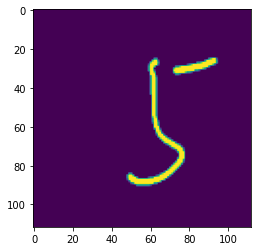

In [ ]:
count = 0
for i in range(X_test.shape[0]):
  pred = model.predict(X_test[i].reshape(1, 112, 112, 1))
  pred = list_categories[np.argmax(pred)]
  true = list_categories[np.argmax(Y_test[i])]
  if pred == true:
    count += 1
print(f"Test Accuracy: {count / X_test.shape[0]}")

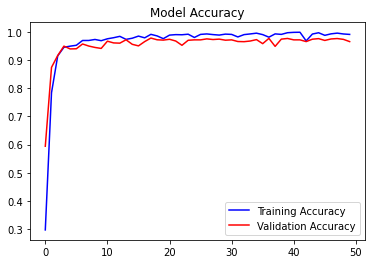

In [ ]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

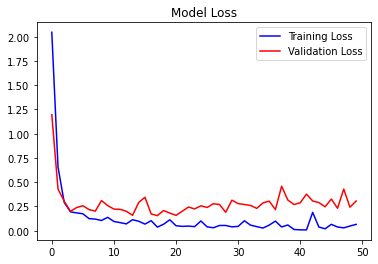

In [ ]:
train_loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
model_json = model.to_json()
with open(f"/content/gdrive/MyDrive/AI Draw Equation/Model/AlexNet lr={lr}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"/content/gdrive/MyDrive/AI Draw Equation/Model/AlexNet lr={lr}.h5")